<a href="https://colab.research.google.com/github/sundi133/chaya-ai-notebook-samples/blob/main/notebooks/colab_covid19_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# ## Uncomment to install
#! pip uninstall  --yes chaya-ai
! pip install fbprophet
! pip install chaya-ai


In [1]:
from chaya_ai.chaya_ai import tracker 

cai = tracker() # increase collaboration and precise feedback

cai.setup(config="/content/chaya-ai-collab.json", project_name="forecasting_covidcases_sample", \
          track={"start_tag":{"keywords":"start|train"},"end_tag":{"metrics":"mean_absolute_error"}}) #use {"metrics":"mean_absolute_error|mean_squared_error"} to track both



Setup succesfull


In [2]:
# Load Python Packages
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Download .csv file from https://ourworldindata.org/coronavirus-source-data
url="https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
df_original = pd.read_csv(url)
df_original.head()



,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Max/Min Date in the data

In [3]:
print(df_original.date.min())
print(df_original.date.max())


2020-01-01
2022-01-01


In [4]:

# Set variables 
country = 'United States' #TODO : 'United States','Canada', 'World'
filter_case = 'new_cases' #TODO : 'total_cases','total_deaths','new_deaths','new_cases'
period_to_forecast = 120

# Filter data
df = df_original.copy()
df = df[df['location']==country]
df.rename(columns={"date": "ds", filter_case: "y"},inplace=True) 
df['ds'] = pd.to_datetime(df['ds'],infer_datetime_format=True)
df['y'] = df['y'].astype(float)
df = df[['y','ds']]

df = df[df['ds']>"2020-02-01"] # covid cases started at this time in US
df_train =  df[df['ds']<"2021-09-07"].reset_index(drop=True)
df_test =  df[(df['ds']>="2021-09-07") & (df['ds']<"2021-10-09")].reset_index(drop=True)

print("training set size")
print(df_train.count())
print("validation set size")
print(df_test.count())


training set size
y     583
ds    583
dtype: int64
validation set size
y     32
ds    32
dtype: int64


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21608541801.865395
131543.2953455162
unable to detect notebook in your env, supported either in self installed cloud vm or local notebooks, google collab or other env is not supported yet, your metrics data send is saved and is available at https://app.chaya.ai
/content/prophetplot.png


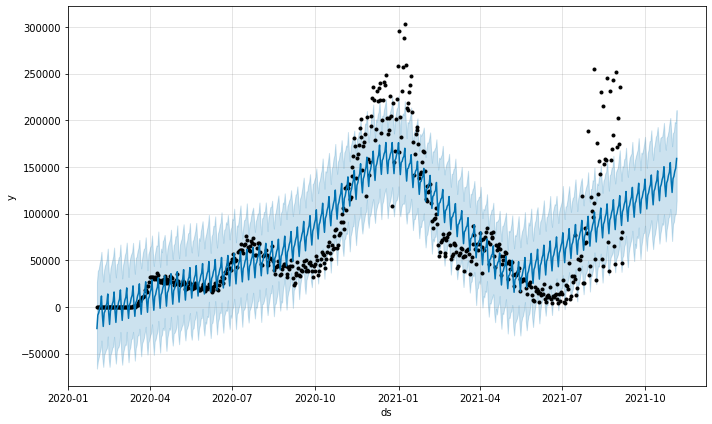

In [5]:

# Run Prophet to get predictions
cai.model_name = "prophet"
cai.save({"train":"start"})
cai.detect_drift(df_train, df_test)
pred = Prophet()
pred.fit(df_train)
future = pred.make_future_dataframe(periods=60)
forecast = pred.predict(future)
#Plot the prediction Graph
graph = pred.plot(forecast)
graph.savefig('prophetplot.png')

#measure mae/mse
forecast_measure = pd.merge(df_test, forecast, left_index=True, right_index=True)
forecast_measure = forecast_measure[['ds_x','yhat','y']]
mse=mean_squared_error(forecast_measure.y, forecast_measure.yhat)
mae=mean_absolute_error(forecast_measure.y, forecast_measure.yhat)
print(mse)
print(mae)

# save in chaya-ai
cai.save({"metric_type":"test", "metrics":{"mean_absolute_error":mae}})
#cai.save({"metric_type":"test", "metrics":{"mean_squared_error":mse, "mean_absolute_error":mae}})
cai.saveplot("/content/prophetplot.png")


In [6]:
from jinja2 import Template
from IPython.display import IFrame, HTML
import os
import json

head = """
    <!-- Load Charts.js -->
    <script src='https://cdnjs.cloudflare.com/ajax/libs/Chart.js/2.5.0/Chart.bundle.min.js'></script>
    """

template = """
    <canvas id='{{div_id}}'></canvas>
    <script>
        var ctx = document.getElementById('{{div_id}}').getContext('2d');
        ctx.canvas.width  = {{w}} - (.1 * {{w}});
        ctx.canvas.height = {{h}} - (.15 * {{h}});
        var myNewChart = new Chart(ctx,{ type: '{{chart_type}}', data: {{data}}, options: {{options}} });
    </script>
"""

def render(data,
               chart_type,
               options=None,
               div_id="chart",
               head="",
               w=800,
               h=420):
   

    return Template(head + template).render(
            div_id=div_id.replace(" ", "_"),
            data=json.dumps(
                data, indent=4).replace("'", "\\'").replace('"', "'"),
            chart_type=chart_type,
            options=json.dumps(
                options, indent=4).replace("'", "\\'").replace('"', "'"),
            w=w,
            h=h)
           

iframe = '<iframe srcdoc="{source}" src="" width="{w}" height="{h}" frameborder="0" sandbox="allow-scripts"></iframe>'

def plot(data, chart_type, options=None, w=800, h=420):
    """Output an iframe containing the plot in the notebook without saving."""
    return HTML(
            iframe.format(
                source=render(
                    data=data,
                    chart_type=chart_type,
                    options=options,
                    head=head,
                    w=w,
                    h=h),
                w=w,
                h=h))

  
filter_key = {}
(data , options) = cai.get_history(filter_key)
     
plot(data, 'line', options=options)




In [7]:

# filter_key = {}
# #filter_key["metric"] = "mae"
# (data , options ) = cai.get_dataset_changepoints(filter_key)


# from jinja2 import Template
# from IPython.display import IFrame, HTML
# import os
# import json

# head = """
#     <!-- Load Charts.js -->
#     <script src='https://cdnjs.cloudflare.com/ajax/libs/Chart.js/2.5.0/Chart.bundle.min.js'></script>
#     """

# template = """
#     <canvas id='{{div_id}}'></canvas>
#     <script>
#         var ctx = document.getElementById('{{div_id}}').getContext('2d');
#         ctx.canvas.width  = {{w}} - (.1 * {{w}});
#         ctx.canvas.height = {{h}} - (.15 * {{h}});
#         var myNewChart = new Chart(ctx,{ type: '{{chart_type}}', data: {{data}}, options: {{options}} });
#     </script>
# """

# def render(data,
#                chart_type,
#                options=None,
#                div_id="chart",
#                head="",
#                w=800,
#                h=420):
   

#     return Template(head + template).render(
#             div_id=div_id.replace(" ", "_"),
#             data=json.dumps(
#                 data, indent=4).replace("'", "\\'").replace('"', "'"),
#             chart_type=chart_type,
#             options=json.dumps(
#                 options, indent=4).replace("'", "\\'").replace('"', "'"),
#             w=w,
#             h=h)



# iframe = '<iframe srcdoc="{source}" src="" width="{w}" height="{h}" frameborder="0" sandbox="allow-scripts"></iframe>'

# def plot(data, chart_type, options=None, w=800, h=420):
#     """Output an iframe containing the plot in the notebook without saving."""
#     return HTML(
#             iframe.format(
#                 source=render(
#                     data=data,
#                     chart_type=chart_type,
#                     options=options,
#                     head=head,
#                     w=w,
#                     h=h),
#                 w=w,
#                 h=h))

        
# plot(data, 'line', options=options)





19337236252.981174
124794.14770436808
/content/prophetplot.png


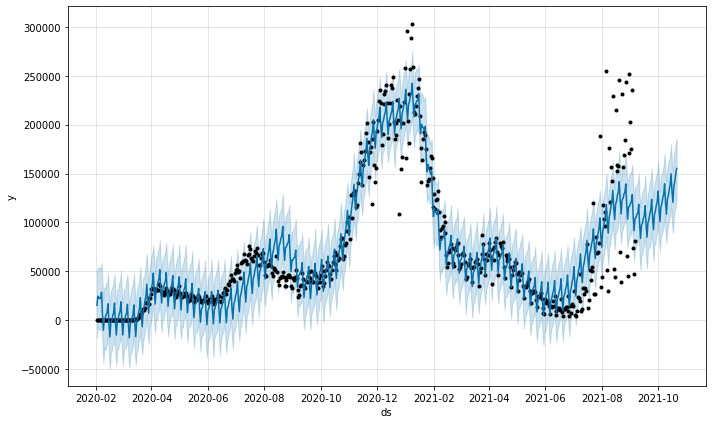

In [8]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

promotions = pd.DataFrame({
  'holiday': 'december_promotion',
  'ds': pd.to_datetime(['2009-12-01', '2010-12-01', '2011-12-01', '2012-12-01',
                        '2013-12-01', '2014-12-01','2015-12-01']),
  'lower_window': 0,
  'upper_window': 0,
})

holidays = pd.concat((playoffs, superbowls, promotions))

cai.save({"train":"start"})
#add seasonality in model
model = Prophet(holidays=holidays, daily_seasonality=True, yearly_seasonality=True)
model.fit(df_train)
future = model.make_future_dataframe(periods=45)
forecast = model.predict(future)
#Plot the prediction Graph
graph = model.plot(forecast)
graph.savefig('prophetplot.png')

#measure mae/mse
forecast_measure = pd.merge(df_test, forecast, left_index=True, right_index=True)
forecast_measure = forecast_measure[['ds_x','yhat','y']]
mse=mean_squared_error(forecast_measure.y, forecast_measure.yhat)
mae=mean_absolute_error(forecast_measure.y, forecast_measure.yhat)
print(mse)
print(mae)

cai.save({"metric_type":"test", "metrics":{"mean_absolute_error":mae}})
#cai.save({"metric_type":"test", "metrics":{"mean_squared_error":mse, "mean_absolute_error":mae}})
cai.saveplot("/content/prophetplot.png")


In [9]:
from tabulate import tabulate
import pandas as pd
from google.colab import data_table

filter_key = {}
filter_key["dataset_version"] = 1
df = cai.get_feature_drifts_dataset_version(filter_key) 
data_table.DataTable(df, include_index=False, num_rows_per_page=100)


,feature,type,drift,value,p_value
1,y,K-S,Yes,0.530446,2.1001098e-08
0,ds,Chi2,No,615.0,0.48103973
